In [1]:
#Import required libraries
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import figure_factory as FF
import numpy as np
import pandas as pd
import scipy
import peakutils
import plotly 
import matplotlib.pyplot as plt


# Scientific libraries
import numpy as np
from scipy.optimize import curve_fit



In [2]:
#Set credentials for plotly online graphing
plotly.tools.set_credentials_file(username='samsam489', api_key='npMuIGuw1fNWQoxuXWaG')

In [3]:
#Read in the cycle data
df = pd.read_excel('../data/130N_Cycles_1-47.xlsx')

In [4]:
#Split the data into times and forces
#df = df.head(n=20000)
times = df['time']
print(times[len(times)-1])
forces = df['load']

16770.9


In [29]:
'''Find the peaks and troughs in the cycles'''
unit_dist = 20
#Convert data frame values into an array to allow for peak finding
forces_array = np.array(forces)
peak_indices = peakutils.indexes(forces_array, thres=0.5, min_dist=100*unit_dist)

#Negate force values to find a trough using the same peak function
negated_forces = -forces
neg_forces_array = np.array(negated_forces)

trough_indices = peakutils.indexes(neg_forces_array, thres=0.5, min_dist=135*unit_dist)

In [30]:
#Convert the index value to a time value for the x-axis
peak_time_indices = [times[i] for i in peak_indices]
trough_time_indices = [times[i] for i in trough_indices]

## Plot the increase in period

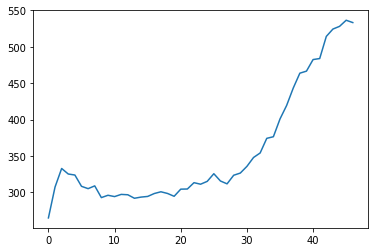

In [32]:
#A period takes place between two consecutive trough times

periods = []

for i in range(len(trough_time_indices) - 1):
    period = trough_time_indices[i+1] - trough_time_indices[i]
    
    periods.append(period)

plt.plot(periods)
plt.show()



In [25]:
#Trace for the original data
trace_standard = go.Scatter(
    x = times, #[j for j in range(len(forces))],
    y = forces,
    mode = 'lines',
    name = 'Original force vs. time'
)

#Trace for the data with uniform time intervals
max_time = times[len(times)-1]
num_time_intervals = len(forces) 


trace_standard_uniform = go.Scatter(
    x = [(max_time/num_time_intervals)*j for j in range(num_time_intervals)],
    y = forces,
    mode = 'lines',
    name = 'Original force vs. time'
)


#Trace for the peaks
trace_peak = go.Scatter(
    x=peak_time_indices,
    y=[forces[j] for j in peak_indices],
    mode='markers',
    marker=dict(
        size=8,
        color='rgb(0,255,0)',
        symbol='cross'
    ),
    name='Detected Peaks'
)

#Trace for the troughs
trace_trough = go.Scatter(
    x=trough_time_indices,
    y=[forces[j] for j in trough_indices],
    mode='markers',
    marker=dict(
        size=8,
        color='rgb(255,0,0)',
        symbol='cross'
    ),
    name='Detected Troughs'
)

In [26]:
#Plot the results
data = [trace_standard, trace_peak, trace_trough,trace_standard_uniform]
py.iplot(data, filename='force-time-plot-with-extrema')

/Users/samcohen/anaconda3/lib/python3.6/site-packages/plotly/plotly/plotly.py:224: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



The draw time for this plot will be slow for all clients.


/Users/samcohen/anaconda3/lib/python3.6/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Too Long



In [9]:
#Label and list the cycles (start-end time pairs) and calculate an average cycle time
cycle_times = []
for i in range(0,len(trough_time_indices)-1, 1): #Subtract 1 in case of incomplete cycles
    cycle = (trough_time_indices[i], trough_time_indices[i+1])
    cycle_times.append(cycle)
#print(cycle_times)
print("Number of cycles: " + str(len(cycle_times)))

average_cycle_time = trough_time_indices[-1] / len(cycle_times)
print("Average cycle time: "+str(average_cycle_time) + " seconds")


Number of cycles: 47
Average cycle time: 356.6510638297872 seconds


In [16]:
#List of heating times (increasing load force) and average heat time (period from low to high)
heating_periods = []
heating_durations = []
total_heating_time = 0
for i in range(0,len(peak_time_indices), 1):
    heat_period = (trough_time_indices[i], peak_time_indices[i])
    heating_periods.append(heat_period)
    total_heating_time += heat_period[1] - heat_period[0]
    heating_durations.append(heat_period[1] - heat_period[0])

    
print("Number of heating periods: "+ str(len(heating_periods)))
print("Total heating time: "+ str(total_heating_time) + " seconds")
print("Average heating time:" +str(total_heating_time/len(heating_periods)) + " seconds")


Number of heating periods: 47
Total heating time: 4290.89919 seconds
Average heating time:91.29572744680851 seconds


In [17]:
#List of cooling times (decreasing load force) and average cool time

cooling_periods = []
cooling_durations = []
total_cooling_time = 0

for i in range(0, len(trough_time_indices)-1, 1):
    cool_period = (peak_time_indices[i], trough_time_indices[i+1]) #Because we start at a trough
    cooling_periods.append(cool_period)
    total_cooling_time += cool_period[1] - cool_period[0]
    cooling_durations.append(cool_period[1] - cool_period[0])

print("Number of cooling periods: "+ str(len(cooling_periods)))
print("Total cooling time: "+ str(total_cooling_time) + " seconds")
print("Average cooling time: " +str(total_cooling_time/len(cooling_periods)) + " seconds")


Number of cooling periods: 47
Total cooling time: 12470.00081 seconds
Average cooling time: 265.3191661702128 seconds


In [32]:

"""
NOTE: we see a steady increase in consecutive heating times and we try to fit a model to this trend.
This increase in heating time seems strange at first, as there is likely internal heat build up which should cause
the muscle to reach its max force more quickly.
However, we note that this increase is likely due to the gradual escape of Ethanol. 
"""

#Plot heating durations
trace_heat_durations = go.Scatter(
    x = [j for j in range(len(heating_durations))],
    y = heating_durations,
    mode = 'lines',
    name = 'heating durations'
)


data = [trace_heat_durations]
layout = go.Layout(
    
    title='Cycle Heating Durations',
    xaxis=dict(
        title='Cycle Count',
        titlefont=dict(
            family='Courier New, monospace',
            size=25,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Time (S)',
        titlefont=dict(
            family='Courier New, monospace',
            size=25,
            color='#7f7f7f'
        )
    )
)

#fig = go.Figure(data=data, layout=layout)
#py.plot(fig, filename='cooling-plot')
fig = go.Figure(data=data, layout=layout)
#py.plot(fig, filename='heating-plot')
##py.iplot(data, filename='Heating durations')


In [33]:
#Rate of increase in cool durations
#Plot the cooling durations
"""
NOTE: Similarly to the heating portion, we see an increase in cooling duration. This is likely due to the same
causes mentioned above.
"""
trace_cool_durations = go.Scatter(
    x = [j for j in range(len(cooling_durations))],
    y = cooling_durations,
    mode = 'lines',
    name = 'Cooling durations'
)
data = [trace_cool_durations]
#py.iplot(data, filename='Cooling durations')

In [34]:
layout = go.Layout(
    title='Cycle Cooling Durations',
    xaxis=dict(
        title='Cycle Count',
        titlefont=dict(
            family='Courier New, monospace',
            size=25,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Time (S)',
        titlefont=dict(
            family='Courier New, monospace',
            size=25,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.plot(fig, filename='cooling-plot')

'https://plot.ly/~samsam489/16'

In [237]:
#Fit potential models to the heating (increased pressure) data
x = [j for j in range(len(heating_durations))]
y = heating_durations

#Fit a 2th degree polynomial
coefs = np.polynomial.polynomial.polyfit(x, y, 2)
ffit = np.poly1d(coefs[::-1])


#Fit an exponential function
def exponenial_func(x, a, b, c):
    return a*np.exp(-b*x)+c

popt, pcov = curve_fit(exponenial_func, x, y, p0=(1, 1e-6, 1))
xx = np.linspace(0,len(heating_durations))#np.linspace(300, 6000, 1000)
yy = exponenial_func(xx, *popt)


print(popt)
print(pcov)

[  2.76799921  -0.08713292  53.09440057]
[[  4.19453021e-01   3.32097949e-03  -1.24525593e+00]
 [  3.32097949e-03   2.65446119e-05  -9.51571034e-03]
 [ -1.24525593e+00  -9.51571034e-03   5.00972033e+00]]


In [239]:
print("Polynomial: ")
print(str(ffit))
print()
print("Exponential:")
#f  = a * e^(-bx) + c 
print("a = "+ str(popt[0]) + " b= "+ str(popt[1]) + " c= "+str(popt[2]))




#Graph both the polynomial and the exponential
trace_heat_durations = go.Scatter(
    x = [j for j in range(len(heating_durations))],
    y = heating_durations,
    mode = 'lines',
    marker=go.Marker(color='rgb(0, 0, 255)'),
    name = 'heating durations'
)

trace_fit_polynomial = go.Scatter(
    x = [j for j in range(len(heating_durations))],
    y = ffit(x),
    mode = 'lines',
    marker=go.Marker(color='rgb(0, 255, 0)'),
    name = 'Polynomial Fit'
)
trace_fit_exponential = go.Scatter(
    x=xx,
    y=yy,
    mode='lines',
    marker=go.Marker(color='rgb(255, 0, 0)'),
    name='Exponential Fit'
)

data = [trace_heat_durations, trace_fit_polynomial, trace_fit_exponential]
py.iplot(data, filename='Heating durations and fits')

Polynomial: 
        2
0.1204 x - 2.929 x + 72.85

Exponential:
a = 2.7679992133 b= -0.0871329186467 c= 53.0944005654
